# Neural Operators in Neuromancer

This tutorial demonstrates the use of learning neural operators for a data driven use case (non-physics informed). 

### References
[1] [Antiderivative operator from an aligned dataset - DeepXDE](https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html)

[2] [DeepONet Tutorial in JAX](https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_operators/simple_deepOnet_in_JAX.ipynb)

## Current issues / TODOs
* Need to implement a problem predict method, why is data['name'] prepended
* Should I be using a callback for keeping track of loss?
* Test notebook on Colaboratory to verify working and correct import list

## Completed tasks
* Tested batch size, batch size must be >= 100 due to dimensions of MLP linear transformation 100x40
* Early stopping working correctly, I accidentally set warmup=epochs during debug
* Add DeepXDE example w/ PyTorch backend to notebook
* Performance comparison for DeepXDE 
    * Time (basic)
    * Decided not to do 
        * Memory
        * Loss (different losses at the moment)
* Neuromancer files edited
    * src/neuromancer/trainer.py - Added loss history for train and dev epochs
    * src/neuromancer/modules/blocks.py - Added DeepONet class definition
* Decided not to add option to initialize linear for MLPs w/ Glorot normal aka xavier uniform
    * [https://pouannes.github.io/blog/initialization/](https://pouannes.github.io/blog/initialization/)
    * [torch.nn.init.xavier_uniform_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_)
* Implemented a DeepONet class inheriting from Block
* Skipping setting up a dev dataset split until we have on the fly generated data
* Verified example works on cpu and mps(gpu equivalent for M1 mac)
* Commited datasets to repo
* Removed DeepXDE example after comparing runtime, hard to do apples to apples comparison

### Install (Colab only)

In [1]:
# !pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"
# !pip install watermark

### Imports

In [2]:
# https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_operators/simple_deepOnet_in_JAX.ipynb
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

# only for development
import sys
sys.path.append('neuromancer_deeponet/src')

In [3]:
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.problem import Problem
from neuromancer.system import Node
from neuromancer.trainer import Trainer

In [5]:
# PyTorch random seed
torch.manual_seed(1234)

# numpy random seed
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Problem Setup

original source: [https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html](https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html)  

We will learn the antiderivative operator 

$$G : v \mapsto u$$

defined by an ODE

$$\frac{du(x)}{dx} = v(x),\;\;x\in [0,1]$$

**Initial Condition:** 
$$u(0) = (0)$$

We learn *G* from a dataset. Each data point in the dataset is one pair of (v,u), generated as follows:

1. A random function *v* is sampled from a Gaussian random field (GRF) with the resolution m = 100.
2. Solve *u* for *v* numerically. We assume that for each *u*, we have the values of *u(x)* in the same N<sub>u</sub> = 100 locations. Because we have the values of *u(x)* in the same locations, we call this dataset as "aligned data".

* Dataset information
    * The training dataset has size 150.
    * The testing dataset has size 1000.
    * Input of the branch net: the functions *v*. It is a matrix of shape (dataset size, m), e.g., (150, 100) for the training dataset.
    * Input of the trunk net: the locations *x* of *u(x)*. It is a matrix of shape (*N<sub>u</sub>*, dimension)
        * i.e., (100,1) for both training and testing datasets.
    * Output: The values of *u(x) in different locations for different *v*. It is a matrix of shape (dataset size, *N<sub>u</sub>*).
        * e.g., (150, 100) for the training dataset.



## Dataset Prep

In [6]:
def prepare_data(dataset, name):
    ## Note: transposing branch input because DictDataset in Neuromancer needs all tensors in the dict to have the same shape at index 0
    branch_inputs = dataset["X"][0].T
    trunk_inputs = dataset["X"][1]
    outputs = dataset["y"].T

    Nu = outputs.shape[0]
    Nsamples = outputs.shape[1]
    print(f'Nu = {Nu}, Nsamples = {Nsamples}')

    # convert to pytorch tensors of float type
    t_branch_inputs_train = torch.from_numpy(branch_inputs).float()
    t_trunk_inputs_train = torch.from_numpy(trunk_inputs).float()
    t_outputs_train = torch.from_numpy(outputs).float()

    data = DictDataset({
        "branch_inputs": t_branch_inputs_train,
        "trunk_inputs": t_trunk_inputs_train,
        "outputs": t_outputs_train
    }, name=name)

    return data, Nu

### Create named dictionary datasets

In [7]:
data_dir = "examples/DeepONets/datasets"
dataset_train = np.load(f"{data_dir}/antiderivative_aligned_train.npz", allow_pickle=True)
train_data, Nu_train = prepare_data(dataset_train, name="train")

dataset_test = np.load(f"{data_dir}/antiderivative_aligned_test.npz", allow_pickle=True)
test_data, Nu_test = prepare_data(dataset_test, name="test")
print(f"Nu_train == Nu_test {Nu_train == Nu_test}")
Nu = Nu_train

Nu = 100
Nsamples = 150
Nu = 100
Nsamples = 1000
Nu_train == Nu_test True


### Create torch DataLoaders for the Trainer

In [8]:
batch_size = 100
print(f"batch_size: {batch_size}")
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, collate_fn=train_data.collate_fn, shuffle=False)
#dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size, collate_fn=dev_data.collate_fn, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=test_data.collate_fn, shuffle=False)

batch_size: 100


## Define node

In [10]:
in_size_branch = Nu
width_size = 40
depth_branch = 2
interact_size = 40
in_size_trunk = 1
depth_trunk = 2
block_deeponet = blocks.DeepONet(
    insize_branch=in_size_branch,
    insize_trunk=in_size_trunk,
    widthsize=width_size,
    interactsize=interact_size,
    depth_branch=depth_branch,
    depth_trunk=depth_trunk,
    nonlin=activations['relu'],
    bias=True
)

In [11]:
node_deeponet = Node(block_deeponet, ['branch_inputs', 'trunk_inputs'], ['g'], name="deeponet")
print(node_deeponet)

deeponet(branch_inputs, trunk_inputs) -> g


## Objective and Constraints in NeuroMANCER

In [12]:
var_y_est = variable("g")
var_y_true = variable("outputs")

# single node class implementation
nodes = [node_deeponet]

var_loss = (var_y_est == var_y_true.T)^2
var_loss.name = "residual_loss"
objectives = [var_loss]

loss = PenaltyLoss(objectives, constraints=[])

problem = Problem(nodes, loss=loss, grad_inference=True)


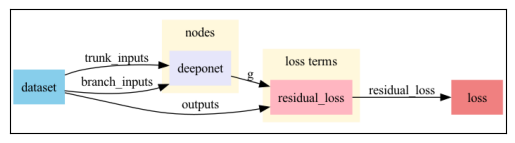

In [13]:
# brew install graphviz
problem.show()

## Problem Solution in NeuroMANCER

In [14]:
lr = 0.001              # step size for gradient descent
epochs = 10000          # number of training epochs
epoch_verbose = 100     # print loss when this many epochs have occurred
warmup = 100            # number of epochs to wait before enacting early stopping policy
patience = 5            #  number of epochs with no improvement in eval metric to allow before early stopping

### Construct Trainer and solve the problem

In [15]:
optimizer = torch.optim.Adam(problem.parameters(), lr=lr) # double check Adam params

#loss_history =
#def LossHistoryCallback(Callback):



# define trainer
trainer = Trainer(
    #problem,
    problem.to(device),
    train_data=train_loader,
    #dev_data=test_loader,
    optimizer=optimizer,
    #callback=LossHistoryCallback()
    epochs=epochs,
    patience=patience,
    epoch_verbose=epoch_verbose,
    train_metric='train_loss',
    dev_metric='train_loss',
    eval_metric="train_loss",
    warmup = warmup,
    device=device
)

In [16]:
%%time
best_model = trainer.train()


epoch: 0  train_loss: 0.2563003599643707
epoch: 100  train_loss: 0.0038055141922086477
epoch: 200  train_loss: 0.0009168362012133002
epoch: 300  train_loss: 0.00036612217081710696
epoch: 400  train_loss: 0.00028798688435927033
epoch: 500  train_loss: 0.00026122541748918593
epoch: 600  train_loss: 0.00023734039859846234
epoch: 700  train_loss: 0.00020793160365428776
epoch: 800  train_loss: 0.00016129233699757606
epoch: 900  train_loss: 9.88554020295851e-05
Early stopping!!!
CPU times: user 4.37 s, sys: 13 s, total: 17.3 s
Wall time: 1.92 s


In [17]:
train_loss_history = [l.detach().cpu().numpy() for l in trainer.loss_history["train"]]
dev_loss_history = [l.detach().cpu().numpy() for l in trainer.loss_history["dev"]]
print(f"len(train_loss_history): {len(train_loss_history)}")
print(f"len(dev_loss_history): {len(dev_loss_history)}")

len(train_loss_history): 958
len(dev_loss_history): 0


## Plot loss history

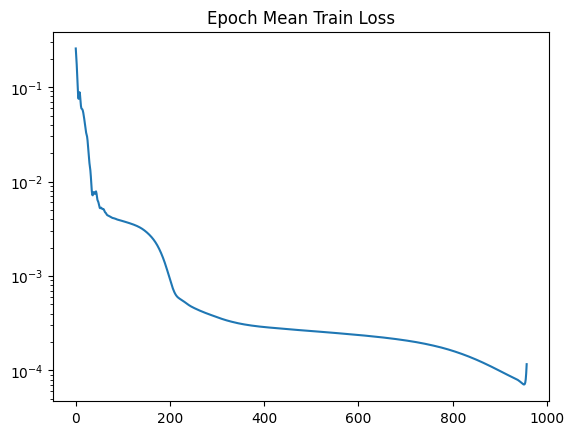

In [18]:
plt.semilogy(train_loss_history)
plt.title("Epoch Mean Train Loss")
plt.show()

## test trainer (need to add dev dataset)

In [19]:
# load best trained model
problem.load_state_dict(best_model)

<All keys matched successfully>

In [20]:
# (not working) Evaluate trained PINN on data (all the data in the domain)
#val_u = problem(train_data.datadict)


## Compare results

torch.Size([100, 1]) torch.Size([100, 1])


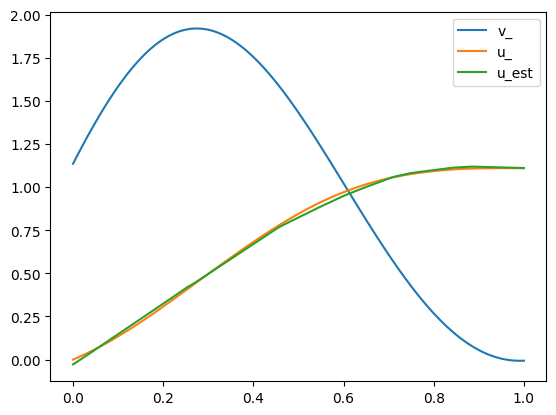

In [21]:
k = 0 # k is the k-th function among the 1000 test functions
v_ = test_data.datadict["branch_inputs"][:,k].reshape(-1,1)
x_ = test_data.datadict["trunk_inputs"]
#v_ = train_data.datadict["branch_inputs"][:,k].reshape(-1,1)
#x_ = train_data.datadict["trunk_inputs"]
print(v_.shape, x_.shape)

v_ = v_.to(device)
x_ = x_.to(device)


## Note: Neuromancer needs a better forward method to 'predict' after the model is trained
## This is a workaround that I found (forward pass with zero 'outputs')
## You could also use a problem.step({'branch_inputs':v_, 'trunk_inputs':x_}) here, but that is not as great
## as it computes the gradients again.
res = problem.step({'branch_inputs':v_, 'trunk_inputs':x_})

u_ = test_data.datadict["outputs"][:,k]
#u_ = train_data.datadict["outputs"][:,k]
u_est = res['g'].T

plt.plot(x_.detach().cpu().numpy(), v_.detach().cpu().numpy(),label='v_')
plt.plot(x_.detach().cpu().numpy(), u_.detach().cpu().numpy(),label='u_')
plt.plot(x_.detach().cpu().numpy(), u_est.detach().cpu().numpy(),label='u_est')

plt.legend()


torch.Size([100, 1]) torch.Size([100, 1])


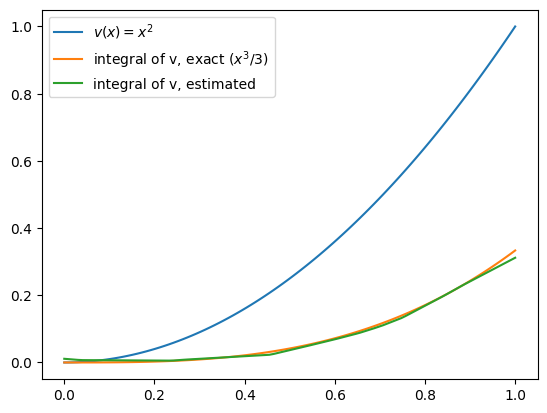

In [22]:
x_ = train_data.datadict["trunk_inputs"]
v_ = torch.pow(x_,2).reshape(-1,1)

print(v_.shape, x_.shape)

v_ = v_.to(device)
x_ = x_.to(device)

res = problem.step({'branch_inputs':v_, 'trunk_inputs':x_})

u_ = (1./3.)*torch.pow(x_,3).reshape(-1,1)
u_est = res['g'].T

plt.plot(x_.detach().cpu().numpy(), v_.detach().cpu().numpy(),label='$v(x) = x^2$')
plt.plot(x_.detach().cpu().numpy(), u_.detach().cpu().numpy(),label='integral of v, exact ($x^3/3$)')
plt.plot(x_.detach().cpu().numpy(), u_est.detach().cpu().numpy(),label='integral of v, estimated')
plt.legend()


### Watermark

In [30]:
%load_ext watermark

In [31]:
%watermark

Last updated: 2024-06-01T12:50:42.263775-07:00

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.24.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit



In [32]:
%watermark --iversions

neuromancer: 1.5.0
torch      : 2.3.0
deepxde    : 1.11.1
sys        : 3.10.14 (main, May  6 2024, 14:42:37) [Clang 14.0.6 ]
matplotlib : 3.8.4
numpy      : 1.23.5

